#### This notebook is for ruunig the reverse model 

In [1]:
import sys
sys.path.insert(0, '../')
import movement_classifier.utils as utils
import movement_classifier.data_loader as data_loader
import movement_classifier.model_funcs as model_funcs
import movement_classifier.gpt_reverse_model as gpt_reverse_model

from os.path import dirname, join as pjoin
import os
import sys
import math

import dlc2kinematics
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from celluloid import Camera
%matplotlib inline
import pandas as pd
import plotly.express as px
import torch
import plotly
from sklearn.decomposition import PCA
import seaborn as sns
import scipy.io as sio

In [2]:
"""load dataframes for the modelling"""
path_file = "../data/03_processed/padding"
data_dict = data_loader.load_data_dict(path_file)

model = model_funcs.Mov1DCNN(num_classes = 20)
input_dict = data_dict
reg = "l2"
params = (model , input_dict   , reg )
my_testmodel = model_funcs.ModelHandler(*params)
"""train model"""
model_trained =  my_testmodel.train()
"""test model"""
my_testmodel.test()

Epoch [1/200], Step [2/9], Loss: 29.9627, Accuracy: 3.00%
Epoch [1/200], Step [4/9], Loss: 6.8602, Accuracy: 14.00%
Epoch [1/200], Step [6/9], Loss: 5.2315, Accuracy: 16.00%
Epoch [1/200], Step [8/9], Loss: 5.2639, Accuracy: 5.00%
Epoch [2/200], Step [2/9], Loss: 5.1624, Accuracy: 15.00%
Epoch [2/200], Step [4/9], Loss: 5.0865, Accuracy: 15.00%
Epoch [2/200], Step [6/9], Loss: 5.0790, Accuracy: 14.00%
Epoch [2/200], Step [8/9], Loss: 4.9873, Accuracy: 21.00%
Epoch [3/200], Step [2/9], Loss: 4.9088, Accuracy: 30.00%
Epoch [3/200], Step [4/9], Loss: 4.9189, Accuracy: 25.00%
Epoch [3/200], Step [6/9], Loss: 4.9338, Accuracy: 26.00%
Epoch [3/200], Step [8/9], Loss: 4.8854, Accuracy: 33.00%
Epoch [4/200], Step [2/9], Loss: 4.7598, Accuracy: 40.00%
Epoch [4/200], Step [4/9], Loss: 4.8610, Accuracy: 17.00%
Epoch [4/200], Step [6/9], Loss: 4.7476, Accuracy: 27.00%
Epoch [4/200], Step [8/9], Loss: 4.7021, Accuracy: 37.00%
Epoch [5/200], Step [2/9], Loss: 4.5521, Accuracy: 33.00%
Epoch [5/200], 

71.55963302752293

In [3]:
input_train= np.load("../data/03_processed/output_train/input.npy")
print(input_train.shape)
out, indices = model_trained(torch.tensor(input_train))

(883, 28, 633)


In [4]:
# visualization_train,labels_name_train,output_train= my_testmodel.layer_extractor(train=True)
reverse_model = gpt_reverse_model.ReverseMov1DCNN(num_classes= 20,maxpool_indices =indices)
reconstuct_out = reverse_model(out)

torch.Size([883, 9672])


In [5]:
visualization_train,labels_name_train,output_train= my_testmodel.layer_extractor(train=True)
rec_out = reconstuct_out.detach().numpy()
np.save("../data/03_processed/reconstructed_input.npy", rec_out)

Visualize the reconstructed data: 

In [6]:

joints = ['ankle1_x', 'knee1_x', 'hip1_x', 'hip2_x', 'knee2_x', 'ankle2_x',
       'wrist1_x', 'elbow1_x', 'shoulder1_x', 'shoulder2_x', 'elbow2_x',
       'wrist2_x', 'chin_x', 'forehead_x', 'ankle1_y', 'knee1_y', 'hip1_y',
       'hip2_y', 'knee2_y', 'ankle2_y', 'wrist1_y', 'elbow1_y', 'shoulder1_y',
       'shoulder2_y', 'elbow2_y', 'wrist2_y', 'chin_y', 'forehead_y']

phone_talking
walking
pointing
phone_talking
kicking not calculated


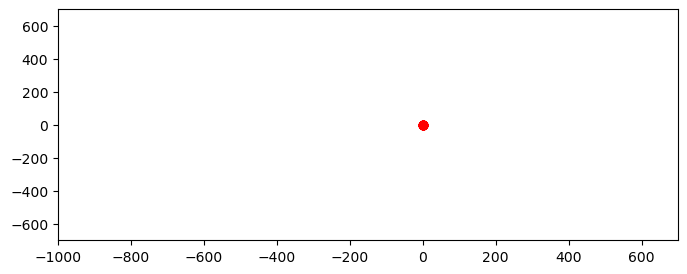

In [8]:

movement_name_list = labels_name_train[0:5]

pick_traj = 5      # Select a trajectory to simulate
fig, ax = plt.subplots(figsize=(8,3))
ax.set(xlim=(-1000, 700), ylim=(-700, 700))
ax.get_xaxis().set_label_coords(0.5, 0.12)

movement_list = ["walking", "jumping_jacks","kicking ","phone_talking","pointing"]
        
for i,motion in enumerate(movement_name_list):
    if motion in movement_list:
        camera = Camera(fig)
        print(motion)
        data = rec_out[i]
        df = pd.DataFrame(data).transpose()
                
        df.columns = joints
        for t in range(df.shape[0]):

                    # Projectile's trajectory
            x = {}
            y = {}
            for j in range(int(len(joints)/2)):
                    x[joints[j]] = df[joints[j]].to_numpy()
                    y[joints[j+14]] = df[joints[j+14]].to_numpy()
                            # Show Projectile's location
                    ax.plot(x[joints[j]][t], y[joints[j+14]][t], marker='o', markersize=4, markeredgecolor='r', markerfacecolor='r')


                    # Show Projectile's trajectory
            ax.plot([x["shoulder1_x"][t],x["chin_x"][t], x["shoulder2_x"][t]],[y["shoulder1_y"][t], y["chin_y"][t],y["shoulder2_y"][t]],'ro-')
            ax.plot([x["shoulder1_x"][t],x["elbow1_x"][t], x["wrist1_x"][t]],[y["shoulder1_y"][t], y["elbow1_y"][t],y["wrist1_y"][t]],'ro-')
            ax.plot([x["shoulder2_x"][t],x["elbow2_x"][t], x["wrist2_x"][t]],[y["shoulder2_y"][t], y["elbow2_y"][t],y["wrist2_y"][t]],'ro-')
            ax.plot([x["shoulder1_x"][t],x["hip1_x"][t], x["hip2_x"][t], x["shoulder2_x"][t]],[y["shoulder1_y"][t], y["hip1_y"][t],y["hip2_y"][t],
            y["shoulder2_y"][t]],'ro-')
            ax.plot([x["hip1_x"][t],x["knee1_x"][t], x["ankle1_x"][t]],[y["hip1_y"][t],y["knee1_y"][t], y["ankle1_y"][t]],'ro-')
            ax.plot([x["hip2_x"][t],x["knee2_x"][t], x["ankle2_x"][t]],[y["hip2_y"][t],y["knee2_y"][t], y["ankle2_y"][t]],'ro-')
            ax.plot([x["forehead_x"][t],x["chin_x"][t]],[y["forehead_y"][t],y["chin_y"][t]],'ro-') 
            
                    # Capture frame
            camera.snap()
        anim = camera.animate(interval = 30, repeat = False)
                # if motion == "throw/catch":
                #     motion = "throw&catch"
        anim.save('../reports/reconstructed_output/{}_{}.mp4'.format(motion,i))
    else:
        print(motion, "not calculated")
            

In [3]:
# run model on reconstructed input
reconstrcuted_input= np.load("../data/03_processed/reconstructed_input.npy")
labels_name_train = np.load("../data/03_processed/output_train/labels_name.npy")
labels_train = np.load("../data/03_processed/output_train/labels.npy")


input_dict = {}
input_dict["input_model"] = reconstrcuted_input
input_dict["labels_name"] = labels_name_train
input_dict["labels"] = labels_train

# model = model_funcs.Mov1DCNN(num_classes = 20)
# reg = "l2"
# params = (model , input_dict   , reg )
# my_testmodel = model_funcs.ModelHandler(*params)
# """train model"""
# model_trained =  my_testmodel.train()
"""test model"""
my_testmodel.test()


(436, 28, 633)
(1319, 20)


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed